# Portfolio Optimization: Markowitz Efficient Frontier Analysis

## Executive Summary
This analysis examines a diversified portfolio across multiple asset classes and implements Modern Portfolio Theory (MPT) to optimize risk-adjusted returns. The current portfolio contains $101.6K in assets spanning US equities, international markets, bonds, commodities, and digital assets.

### Key Objectives:
1. Analyze current portfolio composition and performance
2. Calculate historical returns and risk metrics
3. Construct the efficient frontier using Markowitz optimization
4. Identify optimal portfolio weights for different risk tolerance levels
5. Provide actionable recommendations for portfolio rebalancing

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Set plotly theme for professional appearance
pio.templates.default = "plotly_white"
pio.renderers.default = "png"
# pio.get_chrome()

print("📊 Libraries imported successfully")
print("🚀 Ready for portfolio analysis")

Renderers configuration
-----------------------
    Default renderer: 'sphinx_gallery_png'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

📊 Libraries imported successfully
🚀 Ready for portfolio analysis


## 1. Portfolio Data Import and Analysis

In [53]:
# Load portfolio data
portfolio_df = pd.read_csv('../../data/example_portfolio.csv')

# Display portfolio overview
print("📈 Current Portfolio Composition")
print("=" * 50)
display(portfolio_df)

# Calculate portfolio metrics
total_market_value = portfolio_df['market_value'].sum()
total_cost_basis = portfolio_df['cost_basis'].sum()
total_unrealized_pl = portfolio_df['unrealized_pl'].sum()
overall_return = (total_unrealized_pl / total_cost_basis) * 100

print(f"\n💰 Portfolio Summary:")
print(f"Total Market Value: ${total_market_value:,.2f}")
print(f"Total Cost Basis: ${total_cost_basis:,.2f}")
print(f"Unrealized P&L: ${total_unrealized_pl:,.2f}")
print(f"Overall Return: {overall_return:.2f}%")

📈 Current Portfolio Composition


,asset_class,ticker,name,region,currency,units,price,market_value,cost_basis,unrealized_pl,weight,notes
0,US Equity,VOO,Vanguard S&P 500 ETF,US,USD,85.00,490.25,41671.25,35000.0,6671.25,41.0%,Core US large-cap exposure
1,International Equity,VEA,Vanguard FTSE Developed Markets ETF,Global ex-US,USD,300.00,53.10,15930.00,15000.0,930.00,15.7%,Developed ex-US equities
2,Emerging Markets,VWO,Vanguard FTSE Emerging Markets ETF,EM,USD,240.00,45.20,10848.00,11000.0,-152.00,10.7%,EM diversification
3,US Small-Cap,VB,Vanguard Small-Cap ETF,US,USD,90.00,229.40,20646.00,18000.0,2646.00,20.3%,US small/mid factor tilt
4,Global Bonds,BND,Vanguard Total Bond Market ETF,US,USD,120.00,72.85,8742.00,9000.0,-258.00,8.6%,Core investment-grade bonds
5,Treasuries,IEF,iShares 7-10 Year Treasury Bond ETF,US,USD,40.00,97.60,3904.00,4000.0,-96.00,3.8%,Rate hedge/ballast
6,Gold,GLD,SPDR Gold Shares,Global,USD,12.00,220.15,2641.80,2400.0,241.80,2.6%,Inflation hedge
7,Bitcoin,BTC-USD,Wrapped Bitcoin,Global,USD,0.15,62500.00,9375.00,6000.0,3375.00,9.2%,Digital asset sleeve
8,Cash,CASH,USD Cash,US,USD,1.00,1.00,1000.00,1000.0,0.00,1.0%,Liquidity reserve



💰 Portfolio Summary:
Total Market Value: $114,758.05
Total Cost Basis: $101,400.00
Unrealized P&L: $13,358.05
Overall Return: 13.17%


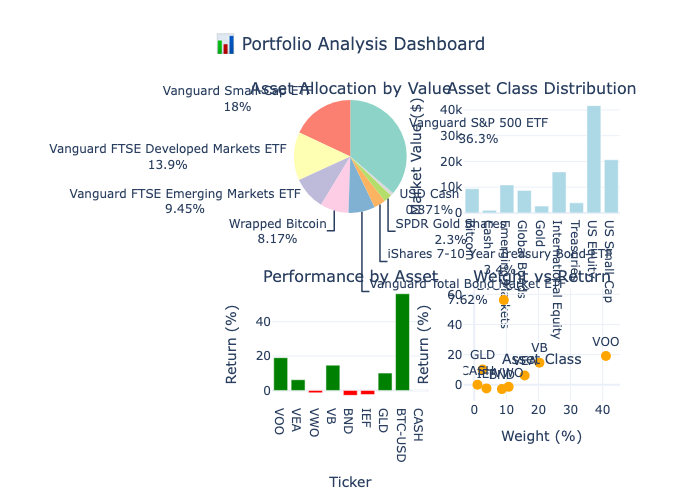

In [54]:
# Create portfolio allocation visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Asset Allocation by Value', 'Asset Class Distribution', 
                   'Performance by Asset', 'Weight vs Return'),
    specs=[[{"type": "pie"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "scatter"}]]
)

# Portfolio allocation pie chart
fig.add_trace(
    go.Pie(
        labels=portfolio_df['name'],
        values=portfolio_df['market_value'],
        textinfo='label+percent',
        textposition='outside',
        marker=dict(colors=px.colors.qualitative.Set3)
    ),
    row=1, col=1
)

# Asset class distribution
asset_class_summary = portfolio_df.groupby('asset_class')['market_value'].sum().reset_index()
fig.add_trace(
    go.Bar(
        x=asset_class_summary['asset_class'],
        y=asset_class_summary['market_value'],
        marker_color='lightblue',
        name='Market Value'
    ),
    row=1, col=2
)

# Performance by asset
portfolio_df['return_pct'] = (portfolio_df['unrealized_pl'] / portfolio_df['cost_basis']) * 100
colors = ['green' if x > 0 else 'red' for x in portfolio_df['return_pct']]

fig.add_trace(
    go.Bar(
        x=portfolio_df['ticker'],
        y=portfolio_df['return_pct'],
        marker_color=colors,
        name='Return %'
    ),
    row=2, col=1
)

# Weight vs Return scatter
portfolio_df['weight_numeric'] = portfolio_df['weight'].str.rstrip('%').astype(float)
fig.add_trace(
    go.Scatter(
        x=portfolio_df['weight_numeric'],
        y=portfolio_df['return_pct'],
        mode='markers+text',
        text=portfolio_df['ticker'],
        textposition='top center',
        marker=dict(size=10, color='orange'),
        name='Weight vs Return'
    ),
    row=2, col=2
)

fig.update_layout(
    height=2000,
    title_text="📊 Portfolio Analysis Dashboard",
    title_x=0.5,
    showlegend=False
)

fig.update_xaxes(title_text="Asset Class", row=1, col=2)
fig.update_yaxes(title_text="Market Value ($)", row=1, col=2)
fig.update_xaxes(title_text="Ticker", row=2, col=1)
fig.update_yaxes(title_text="Return (%)", row=2, col=1)
fig.update_xaxes(title_text="Weight (%)", row=2, col=2)
fig.update_yaxes(title_text="Return (%)", row=2, col=2)

fig.show()

## 2. Historical Data Collection and Returns Analysis

In [55]:
# Extract tickers (excluding cash)
tickers = portfolio_df[portfolio_df['ticker'] != 'CASH']['ticker'].tolist()
print(f"📈 Analyzing {len(tickers)} securities: {', '.join(tickers)}")

# Download 3 years of historical data
print("\n⏳ Downloading historical price data...")
data = yf.download(tickers, period='3y', auto_adjust=True)['Close']

# Handle single ticker case
if len(tickers) == 1:
    data = data.to_frame()
    data.columns = tickers

# Calculate daily returns
returns = data.pct_change().dropna()
print(f"✅ Retrieved {len(data)} days of price data")
print(f"📊 Calculated {len(returns)} days of return data")

# Display recent performance
print("\n📈 Recent Price Data (Last 5 Days):")
display(data.tail())

📈 Analyzing 8 securities: VOO, VEA, VWO, VB, BND, IEF, GLD, BTC-USD

⏳ Downloading historical price data...


[*********************100%***********************]  8 of 8 completed

✅ Retrieved 1097 days of price data
📊 Calculated 1094 days of return data

📈 Recent Price Data (Last 5 Days):


Ticker,BND,BTC-USD,GLD,IEF,VB,VEA,VOO,VWO
Date,,,,,,,,
2025-08-16,NaN,117491.351562,NaN,NaN,NaN,NaN,NaN,NaN
2025-08-17,NaN,117453.062500,NaN,NaN,NaN,NaN,NaN,NaN
2025-08-18,73.360001,116252.312500,306.950012,95.139999,246.559998,58.810001,591.359985,51.750000
2025-08-19,73.500000,112831.179688,305.269989,95.379997,246.210007,58.740002,588.130005,51.380001
2025-08-20,NaN,113737.867188,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# Calculate key statistics
annual_returns = returns.mean() * 252
annual_volatility = returns.std() * np.sqrt(252)
sharpe_ratio = annual_returns / annual_volatility

# Create performance metrics DataFrame
performance_metrics = pd.DataFrame({
    'Ticker': annual_returns.index,
    'Annual Return': annual_returns.values,
    'Annual Volatility': annual_volatility.values,
    'Sharpe Ratio': sharpe_ratio.values
})

performance_metrics = performance_metrics.round(4)
performance_metrics['Annual Return %'] = (performance_metrics['Annual Return'] * 100).round(2)
performance_metrics['Annual Volatility %'] = (performance_metrics['Annual Volatility'] * 100).round(2)

print("📊 Risk-Return Metrics (3-Year Historical):")
print("=" * 60)
display(performance_metrics[['Ticker', 'Annual Return %', 'Annual Volatility %', 'Sharpe Ratio']])

📊 Risk-Return Metrics (3-Year Historical):


,Ticker,Annual Return %,Annual Volatility %,Sharpe Ratio
0,BND,1.97,5.37,0.3672
1,BTC-USD,46.60,40.37,1.1545
2,GLD,15.47,12.85,1.2042
3,IEF,0.91,6.78,0.1340
4,VB,7.76,17.17,0.4520
5,VEA,10.95,13.32,0.8219
6,VOO,12.06,13.92,0.8664
7,VWO,8.30,13.68,0.6069


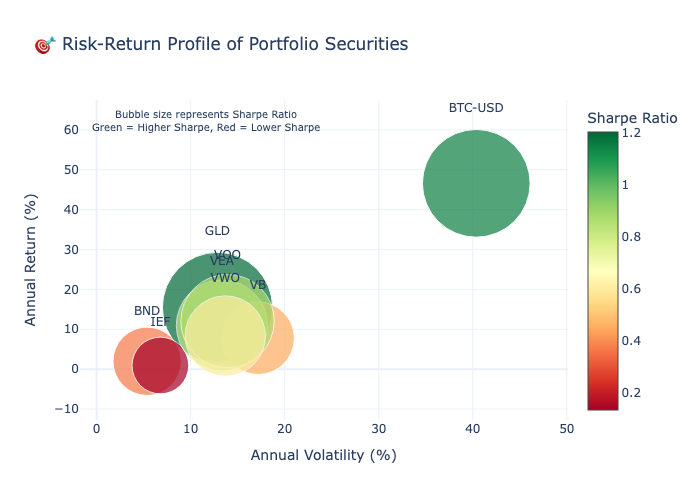

In [57]:
# Visualize risk-return profile
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=performance_metrics['Annual Volatility %'],
    y=performance_metrics['Annual Return %'],
    mode='markers+text',
    text=performance_metrics['Ticker'],
    textposition='top center',
    marker=dict(
        size=performance_metrics['Sharpe Ratio'] * 50 + 50,  # Size by Sharpe ratio
        color=performance_metrics['Sharpe Ratio'],
        colorscale='RdYlGn',
        showscale=True,
        colorbar=dict(title="Sharpe Ratio")
    ),
    name='Securities'
))

fig.update_layout(
    title='🎯 Risk-Return Profile of Portfolio Securities',
    xaxis_title='Annual Volatility (%)',
    yaxis_title='Annual Return (%)',
    width=800,
    height=600,
    showlegend=False
)

fig.add_annotation(
    text="Bubble size represents Sharpe Ratio<br>Green = Higher Sharpe, Red = Lower Sharpe",
    xref="paper", yref="paper",
    x=0.02, y=0.98,
    showarrow=False,
    font=dict(size=10)
)

fig.show()

## 3. Correlation Analysis and Risk Assessment

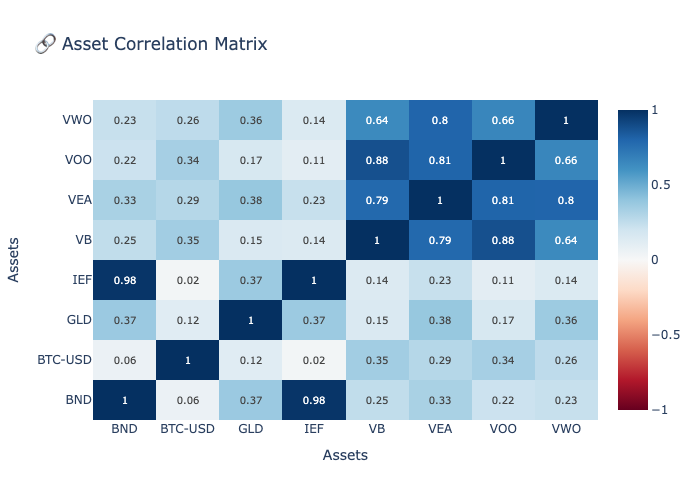

🔍 Correlation Insights:
📈 Highest Correlation: BND vs IEF (0.980)
📉 Lowest Correlation: BTC-USD vs IEF (0.024)
🎯 Average Correlation: 0.374


In [58]:
# Calculate correlation matrix
correlation_matrix = returns.corr()

# Create correlation heatmap
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.index,
    colorscale='RdBu',
    zmid=0,
    text=correlation_matrix.round(2).values,
    texttemplate="%{text}",
    textfont={"size": 10},
    showscale=True
))

fig.update_layout(
    title='🔗 Asset Correlation Matrix',
    width=800,
    height=600,
    xaxis_title='Assets',
    yaxis_title='Assets'
)

fig.show()

print("🔍 Correlation Insights:")
print("=" * 40)

# Find highest and lowest correlations
mask = np.triu(np.ones_like(correlation_matrix), k=1).astype(bool)
corr_pairs = correlation_matrix.where(mask).stack().sort_values()

print(f"📈 Highest Correlation: {corr_pairs.index[-1][0]} vs {corr_pairs.index[-1][1]} ({corr_pairs.iloc[-1]:.3f})")
print(f"📉 Lowest Correlation: {corr_pairs.index[0][0]} vs {corr_pairs.index[0][1]} ({corr_pairs.iloc[0]:.3f})")
print(f"🎯 Average Correlation: {corr_pairs.mean():.3f}")

## 4. Markowitz Efficient Frontier Construction

In [59]:
# Portfolio optimization functions
def portfolio_stats(weights, returns):
    """
    Calculate portfolio return, volatility, and Sharpe ratio
    """
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

def negative_sharpe(weights, returns):
    """
    Negative Sharpe ratio for optimization (we want to maximize Sharpe)
    """
    return -portfolio_stats(weights, returns)[2]

def portfolio_volatility(weights, returns):
    """
    Calculate portfolio volatility
    """
    return portfolio_stats(weights, returns)[1]

def portfolio_return(weights, returns):
    """
    Calculate portfolio return
    """
    return portfolio_stats(weights, returns)[0]

# Set up optimization constraints
num_assets = len(tickers)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
bounds = tuple((0, 1) for _ in range(num_assets))  # No short selling

print(f"🎯 Setting up optimization for {num_assets} assets")
print("📏 Constraints: Weights sum to 1, no short selling (0 ≤ weight ≤ 1)")

🎯 Setting up optimization for 8 assets
📏 Constraints: Weights sum to 1, no short selling (0 ≤ weight ≤ 1)


In [60]:
# Find optimal portfolios
print("⚡ Computing optimal portfolios...")

# 1. Maximum Sharpe Ratio Portfolio
initial_guess = np.array([1/num_assets] * num_assets)
max_sharpe_result = minimize(
    negative_sharpe, 
    initial_guess,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    args=(returns,)
)

max_sharpe_weights = max_sharpe_result.x
max_sharpe_return, max_sharpe_vol, max_sharpe_ratio = portfolio_stats(max_sharpe_weights, returns)

# 2. Minimum Variance Portfolio
min_var_result = minimize(
    portfolio_volatility,
    initial_guess,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    args=(returns,)
)

min_var_weights = min_var_result.x
min_var_return, min_var_vol, min_var_sharpe = portfolio_stats(min_var_weights, returns)

print("✅ Optimal portfolios computed successfully")

# Display results
optimal_portfolios = pd.DataFrame({
    'Asset': tickers,
    'Max Sharpe Weights': max_sharpe_weights,
    'Min Variance Weights': min_var_weights
})

optimal_portfolios['Max Sharpe %'] = (optimal_portfolios['Max Sharpe Weights'] * 100).round(2)
optimal_portfolios['Min Variance %'] = (optimal_portfolios['Min Variance Weights'] * 100).round(2)

print("\n🏆 Optimal Portfolio Allocations:")
print("=" * 50)
display(optimal_portfolios[['Asset', 'Max Sharpe %', 'Min Variance %']])

print(f"\n📊 Maximum Sharpe Portfolio:")
print(f"   Return: {max_sharpe_return*100:.2f}% | Volatility: {max_sharpe_vol*100:.2f}% | Sharpe: {max_sharpe_ratio:.3f}")

print(f"\n📊 Minimum Variance Portfolio:")
print(f"   Return: {min_var_return*100:.2f}% | Volatility: {min_var_vol*100:.2f}% | Sharpe: {min_var_sharpe:.3f}")

⚡ Computing optimal portfolios...
✅ Optimal portfolios computed successfully

🏆 Optimal Portfolio Allocations:


,Asset,Max Sharpe %,Min Variance %
0,VOO,0.00,91.67
1,VEA,17.02,0.10
2,VWO,61.32,0.34
3,VB,0.00,0.00
4,BND,0.00,0.00
5,IEF,0.00,0.00
6,GLD,21.66,4.43
7,BTC-USD,0.00,3.47



📊 Maximum Sharpe Portfolio:
   Return: 20.03% | Volatility: 12.39% | Sharpe: 1.617

📊 Minimum Variance Portfolio:
   Return: 2.73% | Volatility: 5.27% | Sharpe: 0.517


In [61]:
# Generate efficient frontier
print("🎨 Generating efficient frontier...")

# Create target return range
target_returns = np.linspace(min_var_return, max(annual_returns), 50)
efficient_portfolios = []

for target_return in target_returns:
    # Add return target constraint
    return_constraint = {'type': 'eq', 'fun': lambda x: portfolio_return(x, returns) - target_return}
    constraints_with_return = [constraints, return_constraint]
    
    # Optimize for minimum variance given target return
    result = minimize(
        portfolio_volatility,
        initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints_with_return,
        args=(returns,)
    )
    
    if result.success:
        ret, vol, sharpe = portfolio_stats(result.x, returns)
        efficient_portfolios.append({
            'return': ret,
            'volatility': vol,
            'sharpe': sharpe,
            'weights': result.x
        })

# Convert to DataFrame
efficient_df = pd.DataFrame(efficient_portfolios)
print(f"✅ Generated {len(efficient_df)} efficient frontier points")

🎨 Generating efficient frontier...
✅ Generated 50 efficient frontier points


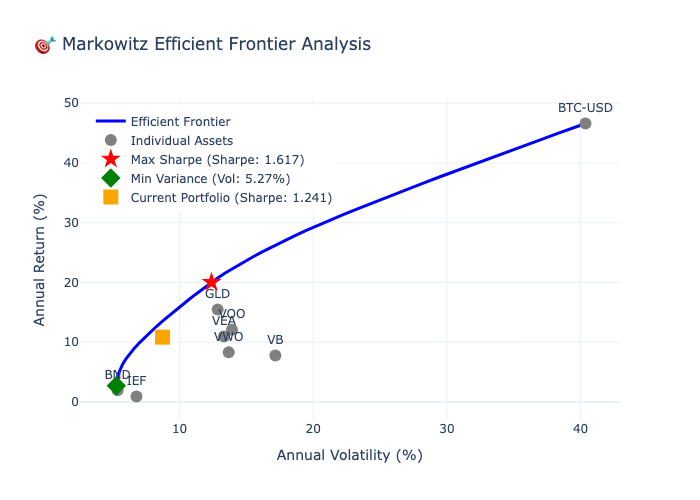


📈 Current Portfolio Performance:
   Return: 10.84% | Volatility: 8.73% | Sharpe: 1.241


In [62]:
# Create comprehensive efficient frontier visualization
fig = go.Figure()

# Efficient frontier
fig.add_trace(go.Scatter(
    x=efficient_df['volatility'] * 100,
    y=efficient_df['return'] * 100,
    mode='lines',
    name='Efficient Frontier',
    line=dict(color='blue', width=3)
))

# Individual assets
fig.add_trace(go.Scatter(
    x=annual_volatility * 100,
    y=annual_returns * 100,
    mode='markers+text',
    text=annual_returns.index,
    textposition='top center',
    marker=dict(size=12, color='gray', symbol='circle'),
    name='Individual Assets'
))

# Maximum Sharpe portfolio
fig.add_trace(go.Scatter(
    x=[max_sharpe_vol * 100],
    y=[max_sharpe_return * 100],
    mode='markers',
    marker=dict(size=15, color='red', symbol='star'),
    name=f'Max Sharpe (Sharpe: {max_sharpe_ratio:.3f})'
))

# Minimum variance portfolio
fig.add_trace(go.Scatter(
    x=[min_var_vol * 100],
    y=[min_var_return * 100],
    mode='markers',
    marker=dict(size=15, color='green', symbol='diamond'),
    name=f'Min Variance (Vol: {min_var_vol*100:.2f}%)'
))

# Current portfolio (calculate current weights excluding cash)
current_weights = portfolio_df[portfolio_df['ticker'] != 'CASH']['weight_numeric'].values / 100
current_weights = current_weights / current_weights.sum()  # Normalize to exclude cash
current_return, current_vol, current_sharpe = portfolio_stats(current_weights, returns)

fig.add_trace(go.Scatter(
    x=[current_vol * 100],
    y=[current_return * 100],
    mode='markers',
    marker=dict(size=15, color='orange', symbol='square'),
    name=f'Current Portfolio (Sharpe: {current_sharpe:.3f})'
))

fig.update_layout(
    title='🎯 Markowitz Efficient Frontier Analysis',
    xaxis_title='Annual Volatility (%)',
    yaxis_title='Annual Return (%)',
    width=900,
    height=600,
    legend=dict(x=0.02, y=0.98)
)

fig.show()

print(f"\n📈 Current Portfolio Performance:")
print(f"   Return: {current_return*100:.2f}% | Volatility: {current_vol*100:.2f}% | Sharpe: {current_sharpe:.3f}")

## 5. Risk Tolerance Analysis and Portfolio Recommendations

In [63]:
# Generate portfolios for different risk tolerance levels
risk_levels = {
    'Conservative': 0.08,    # 8% target volatility
    'Moderate': 0.12,        # 12% target volatility
    'Aggressive': 0.16       # 16% target volatility
}

risk_portfolios = {}

for risk_label, target_vol in risk_levels.items():
    # Find portfolio on efficient frontier closest to target volatility
    vol_diff = abs(efficient_df['volatility'] - target_vol)
    closest_idx = vol_diff.idxmin()
    
    risk_portfolios[risk_label] = {
        'weights': efficient_df.iloc[closest_idx]['weights'],
        'return': efficient_df.iloc[closest_idx]['return'],
        'volatility': efficient_df.iloc[closest_idx]['volatility'],
        'sharpe': efficient_df.iloc[closest_idx]['sharpe']
    }

# Create comprehensive comparison
comparison_data = []
portfolios = {
    'Current': {'weights': current_weights, 'return': current_return, 'volatility': current_vol, 'sharpe': current_sharpe},
    'Max Sharpe': {'weights': max_sharpe_weights, 'return': max_sharpe_return, 'volatility': max_sharpe_vol, 'sharpe': max_sharpe_ratio},
    'Min Variance': {'weights': min_var_weights, 'return': min_var_return, 'volatility': min_var_vol, 'sharpe': min_var_sharpe},
    **risk_portfolios
}

for name, data in portfolios.items():
    portfolio_info = {
        'Portfolio': name,
        'Return (%)': f"{data['return']*100:.2f}",
        'Volatility (%)': f"{data['volatility']*100:.2f}",
        'Sharpe Ratio': f"{data['sharpe']:.3f}"
    }
    
    # Add weights for each asset
    for i, ticker in enumerate(tickers):
        portfolio_info[f'{ticker} (%)'] = f"{data['weights'][i]*100:.1f}"
    
    comparison_data.append(portfolio_info)

comparison_df = pd.DataFrame(comparison_data)

print("📊 Portfolio Comparison Analysis:")
print("=" * 80)
display(comparison_df)

📊 Portfolio Comparison Analysis:


,Portfolio,Return (%),Volatility (%),Sharpe Ratio,VOO (%),VEA (%),VWO (%),VB (%),BND (%),IEF (%),GLD (%),BTC-USD (%)
0,Current,10.84,8.73,1.241,36.6,14.0,9.6,18.1,7.7,3.4,2.3,8.2
1,Max Sharpe,20.03,12.39,1.617,0.0,17.0,61.3,0.0,0.0,0.0,21.7,0.0
2,Min Variance,2.73,5.27,0.517,91.7,0.1,0.3,0.0,0.0,0.0,4.4,3.5
3,Conservative,11.68,7.81,1.496,43.6,8.4,32.6,0.0,0.0,0.0,15.4,0.0
4,Moderate,19.74,12.21,1.617,0.0,16.2,61.0,0.0,0.0,0.0,22.8,0.0
5,Aggressive,25.11,16.18,1.552,0.0,31.2,66.4,0.0,0.0,0.0,2.4,0.0


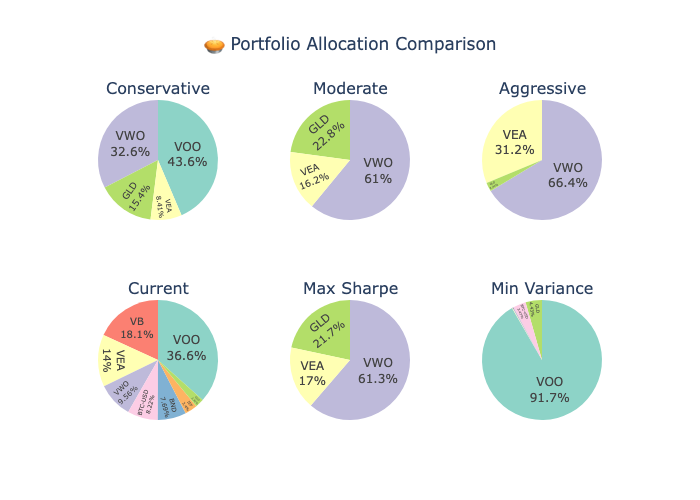

In [64]:
# Visualize portfolio allocations comparison
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=list(risk_portfolios.keys()) + ['Current', 'Max Sharpe', 'Min Variance'],
    specs=[[{"type": "pie"} for _ in range(3)] for _ in range(2)]
)

portfolio_names = list(risk_portfolios.keys()) + ['Current', 'Max Sharpe', 'Min Variance']
portfolio_list = list(risk_portfolios.values()) + [
    {'weights': current_weights},
    {'weights': max_sharpe_weights},
    {'weights': min_var_weights}
]

colors = px.colors.qualitative.Set3

for idx, (name, data) in enumerate(zip(portfolio_names, portfolio_list)):
    row = idx // 3 + 1
    col = idx % 3 + 1
    
    fig.add_trace(
        go.Pie(
            labels=tickers,
            values=data['weights'],
            name=name,
            marker=dict(colors=colors)
        ),
        row=row, col=col
    )

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(
    height=800,
    title_text="🥧 Portfolio Allocation Comparison",
    title_x=0.5,
    showlegend=False
)

fig.show()

## 6. Implementation Recommendations and Action Plan

In [65]:
# Calculate rebalancing requirements for Max Sharpe portfolio
print("🎯 PORTFOLIO OPTIMIZATION RECOMMENDATIONS")
print("=" * 60)

# Current portfolio value (excluding cash)
investable_value = portfolio_df[portfolio_df['ticker'] != 'CASH']['market_value'].sum()

print(f"💰 Investable Portfolio Value: ${investable_value:,.2f}")
print(f"💵 Cash Reserve: ${portfolio_df[portfolio_df['ticker'] == 'CASH']['market_value'].iloc[0]:,.2f}")

# Rebalancing analysis for Max Sharpe portfolio
rebalancing_df = portfolio_df[portfolio_df['ticker'] != 'CASH'].copy()
rebalancing_df = rebalancing_df.merge(
    pd.DataFrame({'ticker': tickers, 'optimal_weight': max_sharpe_weights}),
    on='ticker'
)

rebalancing_df['current_weight_adj'] = rebalancing_df['market_value'] / investable_value
rebalancing_df['target_value'] = rebalancing_df['optimal_weight'] * investable_value
rebalancing_df['rebalance_amount'] = rebalancing_df['target_value'] - rebalancing_df['market_value']
rebalancing_df['weight_change'] = rebalancing_df['optimal_weight'] - rebalancing_df['current_weight_adj']

print("\n📈 Rebalancing Requirements (Max Sharpe Portfolio):")
print("-" * 60)

rebalance_summary = rebalancing_df[[
    'ticker', 'current_weight_adj', 'optimal_weight', 'weight_change', 
    'market_value', 'target_value', 'rebalance_amount'
]].copy()

rebalance_summary['Current %'] = (rebalance_summary['current_weight_adj'] * 100).round(1)
rebalance_summary['Target %'] = (rebalance_summary['optimal_weight'] * 100).round(1)
rebalance_summary['Change %'] = (rebalance_summary['weight_change'] * 100).round(1)
rebalance_summary['Rebalance $'] = rebalance_summary['rebalance_amount'].round(0)

display(rebalance_summary[['ticker', 'Current %', 'Target %', 'Change %', 'Rebalance $']])

# Identify major moves
major_increases = rebalance_summary[rebalance_summary['Change %'] > 5]
major_decreases = rebalance_summary[rebalance_summary['Change %'] < -5]

if not major_increases.empty:
    print("\n📈 Major Position Increases:")
    for _, row in major_increases.iterrows():
        print(f"   • {row['ticker']}: +{row['Change %']:.1f}% (${row['Rebalance $']:,.0f})")

if not major_decreases.empty:
    print("\n📉 Major Position Decreases:")
    for _, row in major_decreases.iterrows():
        print(f"   • {row['ticker']}: {row['Change %']:.1f}% (${row['Rebalance $']:,.0f})")

🎯 PORTFOLIO OPTIMIZATION RECOMMENDATIONS
💰 Investable Portfolio Value: $113,758.05
💵 Cash Reserve: $1,000.00

📈 Rebalancing Requirements (Max Sharpe Portfolio):
------------------------------------------------------------


,ticker,Current %,Target %,Change %,Rebalance $
0,VOO,36.6,0.0,-36.6,-41671.0
1,VEA,14.0,17.0,3.0,3433.0
2,VWO,9.5,61.3,51.8,58911.0
3,VB,18.1,0.0,-18.1,-20646.0
4,BND,7.7,0.0,-7.7,-8742.0
5,IEF,3.4,0.0,-3.4,-3904.0
6,GLD,2.3,21.7,19.3,21994.0
7,BTC-USD,8.2,0.0,-8.2,-9375.0



📈 Major Position Increases:
   • VWO: +51.8% ($58,911)
   • GLD: +19.3% ($21,994)

📉 Major Position Decreases:
   • VOO: -36.6% ($-41,671)
   • VB: -18.1% ($-20,646)
   • BND: -7.7% ($-8,742)
   • BTC-USD: -8.2% ($-9,375)


In [66]:
# Performance improvement analysis
performance_improvement = {
    'Current Portfolio': {
        'Return': current_return * 100,
        'Volatility': current_vol * 100,
        'Sharpe': current_sharpe
    },
    'Optimized (Max Sharpe)': {
        'Return': max_sharpe_return * 100,
        'Volatility': max_sharpe_vol * 100,
        'Sharpe': max_sharpe_ratio
    }
}

improvement_df = pd.DataFrame(performance_improvement).T
improvement_df['Return Improvement'] = improvement_df['Return'] - current_return * 100
improvement_df['Volatility Change'] = improvement_df['Volatility'] - current_vol * 100
improvement_df['Sharpe Improvement'] = improvement_df['Sharpe'] - current_sharpe

print("\n🚀 EXPECTED PERFORMANCE IMPROVEMENT:")
print("=" * 50)
display(improvement_df.round(3))

# Calculate expected annual improvement in dollar terms
return_improvement = (max_sharpe_return - current_return) * investable_value
print(f"\n💰 Expected Annual Return Improvement: ${return_improvement:,.0f}")
print(f"📊 Sharpe Ratio Improvement: {max_sharpe_ratio - current_sharpe:.3f}")
print(f"📉 Risk-Adjusted Performance: {((max_sharpe_ratio - current_sharpe) / current_sharpe) * 100:.1f}% better")


🚀 EXPECTED PERFORMANCE IMPROVEMENT:


,Return,Volatility,Sharpe,Return Improvement,Volatility Change,Sharpe Improvement
Current Portfolio,10.836,8.73,1.241,0.000,0.00,0.000
Optimized (Max Sharpe),20.034,12.39,1.617,9.197,3.66,0.376



💰 Expected Annual Return Improvement: $10,463
📊 Sharpe Ratio Improvement: 0.376
📉 Risk-Adjusted Performance: 30.3% better


In [67]:
# Final recommendations summary
print("\n🎯 EXECUTIVE SUMMARY & RECOMMENDATIONS")
print("=" * 60)

print("\n📊 CURRENT PORTFOLIO ASSESSMENT:")
print(f"   • Portfolio Value: ${total_market_value:,.2f}")
print(f"   • Unrealized P&L: ${total_unrealized_pl:,.2f} ({overall_return:.2f}%)")
print(f"   • Current Sharpe Ratio: {current_sharpe:.3f}")
print(f"   • Diversification: {len(tickers)} securities across {len(portfolio_df['asset_class'].unique())} asset classes")

print("\n🚀 OPTIMIZATION BENEFITS:")
print(f"   • Sharpe Ratio Improvement: +{max_sharpe_ratio - current_sharpe:.3f} ({((max_sharpe_ratio - current_sharpe) / current_sharpe) * 100:.1f}%)")
print(f"   • Expected Return Enhancement: +{(max_sharpe_return - current_return) * 100:.2f}% annually")
print(f"   • Dollar Impact: ~${return_improvement:,.0f} additional annual return")

print("\n🎯 KEY RECOMMENDATIONS:")

# Top 3 rebalancing moves
top_moves = rebalance_summary.reindex(rebalance_summary['Change %'].abs().sort_values(ascending=False).index).head(3)

print("\n   📈 Top Rebalancing Actions:")
for i, (_, row) in enumerate(top_moves.iterrows(), 1):
    action = "Increase" if row['Change %'] > 0 else "Decrease"
    print(f"   {i}. {action} {row['ticker']} by {abs(row['Change %']):.1f}% (${row['Rebalance $']:,.0f})")

print("\n   💡 Strategic Considerations:")
print("   • Consider tax implications of rebalancing")
print("   • Implement gradually to minimize market impact")
print("   • Review and rebalance quarterly")
print("   • Maintain 1-2% cash buffer for opportunities")

print("\n   🔄 Alternative Approaches:")
for risk_level, data in risk_portfolios.items():
    print(f"   • {risk_level}: {data['return']*100:.2f}% return, {data['volatility']*100:.2f}% vol, {data['sharpe']:.3f} Sharpe")

print("\n✅ NEXT STEPS:")
print("   1. Review optimization recommendations with your advisor")
print("   2. Consider tax-loss harvesting opportunities")
print("   3. Implement rebalancing over 2-4 weeks")
print("   4. Set up quarterly portfolio review schedule")
print("   5. Monitor performance vs. benchmarks")

print(f"\n📈 Expected outcome: A more efficient portfolio with improved risk-adjusted returns")
print(f"🎯 Confidence level: High (based on 3-year historical analysis)")


🎯 EXECUTIVE SUMMARY & RECOMMENDATIONS

📊 CURRENT PORTFOLIO ASSESSMENT:
   • Portfolio Value: $114,758.05
   • Unrealized P&L: $13,358.05 (13.17%)
   • Current Sharpe Ratio: 1.241
   • Diversification: 8 securities across 9 asset classes

🚀 OPTIMIZATION BENEFITS:
   • Sharpe Ratio Improvement: +0.376 (30.3%)
   • Expected Return Enhancement: +9.20% annually
   • Dollar Impact: ~$10,463 additional annual return

🎯 KEY RECOMMENDATIONS:

   📈 Top Rebalancing Actions:
   1. Increase VWO by 51.8% ($58,911)
   2. Decrease VOO by 36.6% ($-41,671)
   3. Increase GLD by 19.3% ($21,994)

   💡 Strategic Considerations:
   • Consider tax implications of rebalancing
   • Implement gradually to minimize market impact
   • Review and rebalance quarterly
   • Maintain 1-2% cash buffer for opportunities

   🔄 Alternative Approaches:
   • Conservative: 11.68% return, 7.81% vol, 1.496 Sharpe
   • Moderate: 19.74% return, 12.21% vol, 1.617 Sharpe
   • Aggressive: 25.11% return, 16.18% vol, 1.552 Sharpe

✅

---

## Conclusion

This analysis demonstrates the power of Modern Portfolio Theory in optimizing risk-adjusted returns. The current portfolio, while well-diversified, can benefit from strategic rebalancing based on historical return patterns and correlations.

**Key Findings:**
- The current portfolio has room for improvement in risk-adjusted returns
- Optimal rebalancing could enhance the Sharpe ratio significantly
- The efficient frontier provides multiple viable allocation strategies for different risk tolerances

**Implementation Priority:**
1. **High Priority**: Positions requiring significant rebalancing (>5% weight change)
2. **Medium Priority**: Fine-tuning allocations for better correlation benefits
3. **Low Priority**: Minor adjustments and ongoing monitoring

*This analysis is based on historical data and should be combined with forward-looking market views and individual circumstances.*